In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from graphviz import Digraph
import argparse
import seaborn as sns
from matplotlib import pyplot as plt
import time
import copy

In [ ]:
def get_column_names(path):
    '''
        Gets the column names from the given path
    '''
    data = pd.read_csv(path)
    return data.columns

In [ ]:
def get_X_y(path):
    """
    Loads the X and y from the given path.
    Assumes last columns of the x are the target values.
    :param path: the path to the x
    :return: the x as X and y numpy arrays
    """
    x = pd.read_csv(path)
    X = x.drop(x.columns[-1], axis=1).to_numpy()
    y = x[x.columns[-1]].to_numpy()
    return X, y




In [ ]:
def train_test_split(X, y, train_size, shuffle=True, seed=42):
    """
    Splits the x into training and test sets.
    :param X: the x
    :param y: the target values
    :param train_size: the size of the training set
    :param shuffle: whether to shuffle the x
    :param seed: the seed for the random generator
    :return: X_train, X_test, y_train, y_test
    """
    # length = len(X)
    # n_train = int(np.ceil(length*train_size))
    # n_test = length - n_train

    # if shuffle:
    #     perm = np.random.RandomState(seed).permutation(length)
    #     test_indices = perm[:n_test]
    #     train_indices = perm[n_test:]
    # else:
    #     train_indices = np.arange(n_train)
    #     test_indices = np.arange(n_train, length)

    # X_train = X[train_indices]
    # X_test = X[test_indices]
    # y_train = y[train_indices]
    # y_test = y[test_indices]
    X_train, X_test, y_train, y_test = tts(
        X, y, stratify=y, test_size=1-train_size, random_state=seed)
    return X_train, X_test, y_train, y_test




In [ ]:
def train_val_test_split(X, y, train_size, val_size, shuffle=True, seed=42):
    '''
    Splits the x into training, validation and test sets.
    :param X: the x
    :param y: the target values
    :param train_size: the size of the training set
    :param val_size: the size of the validation set
    :param shuffle: whether to shuffle the x
    :param seed: the seed for the random generator
    :return: X_train, X_val, X_test, y_train, y_val, y_test
    '''
    # length = len(X)
    # n_train = int(np.ceil(length*train_size))
    # n_val = int(np.ceil(length*val_size))
    # n_test = length - n_train - n_val

    # if shuffle:
    #     perm = np.random.RandomState(seed).permutation(length)
    #     test_indices = perm[:n_test]
    #     val_indices = perm[n_test:n_test+n_val]
    #     train_indices = perm[n_test+n_val:]
    # else:
    #     train_indices = np.arange(n_train)
    #     val_indices = np.arange(n_train, n_train + n_val)
    #     test_indices = np.arange(n_train + n_val, length)

    # X_train = X[train_indices]
    # X_val = X[val_indices]
    # X_test = X[test_indices]
    # y_train = y[train_indices]
    # y_val = y[val_indices]
    # y_test = y[test_indices]

    test_size = 1-train_size-val_size
    X_train, X_temp, y_train, y_temp = tts(
        X, y, stratify=y, test_size=(1.0 - train_size), random_state=seed)
    relative_test_size = test_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = tts(
        X_temp, y_temp, stratify=y_temp, test_size=relative_test_size, random_state=seed)
    return X_train, X_val, X_test, y_train, y_val, y_test




In [ ]:
def check_purity(y):
    """
    Checks if the given array is pure.
    :param y: the array
    :return: True if the array is pure, False otherwise
    """
    return len(set(y)) == 1




In [ ]:
def classify_array(y):
    """
    Classifies the array into a single class.
    find most common number and return that
    :param y: the array
    :return: the class
    """
    classes, counts = np.unique(y, return_counts=True)
    return classes[counts.argmax()]
    # return np.argmax(np.bincount(y.astype(int)))




In [ ]:
def get_possible_breaks(X, type_arr):
    '''
        Calculates possible breaks for a given set of features 
    '''
    breaks = {}
    for col_idx in range(X.shape[1]):
        unique_vals = np.unique(X[:, col_idx])
        num_vals = np.unique(X[:, col_idx]).shape[0]

        type = type_arr[col_idx]
        if type == "cont":
            breaks[col_idx] = []
            for i in range(1, num_vals):
                current_value = unique_vals[i]
                previous_value = unique_vals[i - 1]
                potential_split = (current_value + previous_value) / 2
                breaks[col_idx].append(potential_split)
        elif num_vals > 1:
            breaks[col_idx] = unique_vals
    return breaks




In [ ]:
def create_children_np(X, y, col_idx, col_val, type_arr):
    '''
        Creates the children of a dataset given split column and value
    '''
    y = y.reshape(-1, 1)
    X_n = np.hstack((X, y))
    relevant_column = X_n[:, col_idx]
    # print(relevant_column)
    # print(relevant_column<=col_val)
    if type_arr[col_idx] == "cont":
        X_one = X_n[relevant_column <= col_val]
        X_two = X_n[relevant_column > col_val]
    else:
        X_one = X_n[relevant_column == col_val]
        X_two = X_n[relevant_column != col_val]

    # print(X_one.shape, X_two.shape)
    Y_one = X_one[:, -1]
    Y_two = X_two[:, -1]
    X_one = X_one[:, :-1]
    X_two = X_two[:, :-1]

    # print(X_one.shape, X_two.shape, Y_one.shape, Y_two.shape)
    return X_one, Y_one, X_two, Y_two




In [ ]:
def calc_entropy_np(y):
    """
    Calculates the entropy of the given array.
    :param y: the array
    :return: the entropy
    """
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return np.sum(probabilities * -np.log2(probabilities))




In [ ]:
def calc_info_gain(X, y, col_idx, col_val, type_arr):
    '''
        Calculates the information gain of a given split
    '''
    X_one, Y_one, X_two, Y_two = create_children_np(
        X, y, col_idx, col_val, type_arr)
    p = len(X_one) / len(X)
    return calc_entropy_np(y) - (p * calc_entropy_np(Y_one) + (1 - p) * calc_entropy_np(Y_two))



In [ ]:
def get_best_split(X, y, type_arr, method="entropy"):
    '''
        Calculates the best split for a given set of features
    '''
    best_col = -1
    best_val = -1
    best_gain = -10000
    breaks = get_possible_breaks(X, type_arr)
    for col_idx in breaks:
        for col_val in breaks[col_idx]:
            if method == "entropy":
                gain = calc_info_gain(X, y, col_idx, col_val, type_arr)
            else:
                gain = calc_gini_gain(X, y, col_idx, col_val, type_arr)
            if gain > best_gain:
                best_col = col_idx
                best_val = col_val
                best_gain = gain
    return best_col, best_val




In [ ]:
def assign_feature_type(X, cont_thresh):
    '''
        Assigns the type of each feature based on the data
    '''
    type_arr = []
    for col_idx in range(X.shape[1]):
        type_val = X[:, col_idx][0]
        unique_vals = np.unique(X[:, col_idx])
        if len(unique_vals) < cont_thresh or isinstance(type_val, str):
            type_arr.append("discrete")
        else:
            type_arr.append("cont")
    return type_arr




In [ ]:
def calc_accuracy(y_true, y_pred):
    '''
        Calculates the accuracy of the prediction
    '''
    return np.sum(y_pred == y_true) / len(y_pred)




In [ ]:
def filter(X, y, col_idx, col_val, type_arr):

    y = y.reshape(-1, 1)
    X_n = np.hstack((X, y))
    relevant_column = X_n[:, col_idx]

    if type_arr[col_idx] == "cont":
        X_yes = X_n[relevant_column <= col_val]
        X_no = X_n[relevant_column > col_val]

    else:
        X_yes = X_n[relevant_column == col_val]
        X_no = X_n[relevant_column != col_val]

    Y_yes = X_yes[:, -1]
    Y_no = X_no[:, -1]
    X_yes = X_yes[:, :-1]
    X_no = X_no[:, :-1]
    return X_yes, Y_yes, X_no, Y_no




In [ ]:
def check_node(X, y):
    return classify_array(y)

In [ ]:
GLOBAL_COUNT=0
class Node:
    '''
        Class defines the nodes of the decision tree
        self.attr: [String] attribute of the node
        self.val: [Float] value of the attribute
        self.avg_attr: [Float] average of the attribute

        self.left: [Node] left child of the node
        self.right: [Node] right child of the node

    '''

    def __init__(self, attribute, value, type_arr):
        '''
            Initializes the node
        '''
        global GLOBAL_COUNT
        GLOBAL_COUNT+=1
        self.node_id=GLOBAL_COUNT
        
        self.attr_idx = attribute
        self.val = value
        self.attr_type = type_arr[self.attr_idx]
        self.left = None
        self.right = None
        self.leaf = False
        self.classification = None

    def make_leaf(self, classification):
        '''
            Makes the node a leaf node
        '''
        # print(f'Making leaf node {classification}')
        self.leaf = True
        self.left = None
        self.right = None
        self.classification = classification

    def get_classification(self):
        '''
            Returns the classification of the node
        '''
        return self.classification

    def predict_node(self, X):
        '''
            Predicts the class of the instance X
        '''
        if self.leaf:
            return self.classification
        else:
            if self.attr_type == 'cont':
                if X[self.attr_idx] <= self.val:
                    return self.left.predict_node(X)
                else:
                    return self.right.predict_node(X)
            else:
                if X[self.attr_idx] == self.val:
                    return self.left.predict_node(X)
                else:
                    return self.right.predict_node(X)

    def __eq__(self, other) -> bool:
        # print(self,other)
        if other is None:
            return False
        if self.leaf and other.leaf:
            return self.classification == other.classification
        if self.attr_idx != other.attr_idx:
            return False
        if self.val != other.val:
            return False
        if self.attr_type != other.attr_type:
            return False
        if self.left != other.left:
            return False
        if self.right != other.right:
            return False
        return True

    def dfs_count(self):
        ans = 1
        if not self.left is None:
            ans += self.left.dfs_count()
        if not self.right is None:
            ans += self.right.dfs_count()
        return ans

    def calc_prune_error(self, X_val, y_val):
        preds = np.array([self.predict_node(x) for x in X_val])
        return np.sum(preds != y_val)

    def prune_base(self, y_train, X_val, y_val, n_node):

        leaf = classify_array(y_train)
        errors_leaf = np.sum(y_val != leaf)
        errors_node = np.sum(y_val != np.array(
            [self.predict_node(x) for x in X_val]))

        if errors_leaf <= errors_node:
            n_node.make_leaf(leaf)
        

    def prune_rec(self, X_train, y_train, X_val, y_val,type_arr):

        n_node = Node(self.attr_idx, self.val, type_arr)
        n_node.leaf = self.leaf
        n_node.classification = self.classification
        n_node.left = self.left
        n_node.right = self.right
        # print(f"start {type(n_node)}")
        if self.leaf:
            n_node = self.prune_base(y_train, X_val, y_val, n_node)

        else:
            X_train_yes, Y_train_yes, X_train_no, Y_train_no = filter(
                X_train, y_train, self.attr_idx, self.val,type_arr)
            X_val_yes, Y_val_yes, X_val_no, Y_val_no = filter(
                X_val, y_val, self.attr_idx, self.val,type_arr)

            if not (self.left is None or self.left.leaf==True):
                n_node.left = self.left.prune_rec(X_train_yes,Y_train_yes, X_val_yes, Y_val_yes,type_arr)
            if not (self.right is None or self.right.leaf==True):
                n_node.right = self.right.prune_rec(X_train_no,Y_train_no, X_val_no, Y_val_no,type_arr)

            self.prune_base(y_train, X_val, y_val, n_node)

        # print(f"end {type(n_node)}")
        return n_node




In [ ]:
class DecisionTree:
    '''
        Class defines the decision tree
        self.root: [Node] root of the tree
        self.X:  [Nest List] training features
        self.y:  [List] training labels
    '''

    def __init__(self, X, y, column_names, min_leaf_size, max_depth,impurity_measure):
        '''
            Initializes the tree
        '''
        self.measure=impurity_measure
        self.root = None
        self.root_pruned = None
        self.X = X
        self.y = y
        self.min_leaf_size = min_leaf_size
        self.max_depth = max_depth
        self.column_names = column_names
        self.type_arr = assign_feature_type(X, 2)

    def fit(self):
        '''
                Builds the decision tree
        '''
        global GLOBAL_COUNT
        GLOBAL_COUNT=0
        self.root = self.build_tree(self.X, self.y)

    def is_leaf(self, X_lo, y_lo):
        '''
            Checks if the node is a leaf
            node: [Node] node to be checked
        '''
        if X_lo.shape[0] <= self.min_leaf_size:
            return True
        if check_purity(y_lo):
            return True
        return False

    def build_tree(self, X, y, depth=0):
        '''
            Recursively builds the decision tree
            node: [Node] node to be built
            depth: [Int] depth of the node
        '''

        
        if self.is_leaf(X, y) or depth == self.max_depth:
            node = Node(0, 0, self.type_arr)
            node.make_leaf(classify_array(y))
            return node
        else:
            depth += 1
            best_attr, best_val = get_best_split(
                X, y, self.type_arr,self.measure)
            node = Node(best_attr, best_val, self.type_arr)
            
            X_left, y_left, X_right, y_right = create_children_np(
                X, y, best_attr, best_val, self.type_arr)
            
            if X_left.shape[0] == 0 or X_right.shape[0] == 0:
                node.make_leaf(classify_array(y))    
                return node

            left_tree = self.build_tree(X_left, y_left, depth)
            right_tree = self.build_tree(X_right, y_right, depth)
            
            # print("hii",left_tree,right_tree)
            if left_tree == right_tree:    
                node.make_leaf(classify_array(y_left))
            else:
                node.leaf = False
                node.left = left_tree
                node.right = right_tree

            return node

    def predict(self, X):
        '''
            Predicts the labels of the test data
            X: [Nest List] test features
        '''
        if self.root is None:
            return None
        else:
            return np.array([self.root.predict_node(x) for x in X])

    def pruned_predict(self, X):
        if self.root_pruned is None:
            return None
        else:
            return np.array([self.root_pruned.predict_node(x) for x in X])

    def calc_accuracy(self, X, y,print_report=True):
        '''
            Calculates the accuracy of the decision tree
            X: [Nest List] test features
            y: [List] test labels
        '''
        y_pred = self.predict(X)
        from sklearn.metrics import classification_report
        if print_report:
            print(classification_report(y, y_pred))
        return calc_accuracy(y, y_pred)

    def calc_pruned_accuracy(self, X, y,print_report=True):
        y_pred = self.pruned_predict(X)
        from sklearn.metrics import classification_report
        if print_report:
            print(classification_report(y, y_pred))
        return calc_accuracy(y, y_pred)

    def print_tree(self, node=None, depth=0):
        '''
            Prints the tree in a readable format
            node: [Node] node to be printed
            depth: [Int] depth of the node
        '''

        if node.leaf:
            print('|'*depth+'Leaf: '+str(node.classification))
        else:
            compoperator = '<='
            if node.attr_type == 'discrete':
                compoperator = '=='
            print('|'*depth+'Attribute: ' +
                  self.column_names[node.attr_idx]+'  ' + compoperator + '  Value: '+str(node.val))
            self.print_tree(node.left, depth+1)
            self.print_tree(node.right, depth+1)

    def count_nodes(self):
        return self.root.dfs_count()

    def post_prune(self, X_train, y_train, X_val, y_val):
        '''
            Recursively prunes the tree
        '''
        global GLOBAL_COUNT
        GLOBAL_COUNT=0
        self.root_pruned = self.root.prune_rec(X_train, y_train, X_val, y_val,self.type_arr)




In [ ]:
def render_node(vertex, feature_names, count):
    if vertex.leaf:
        return f'ID {vertex.node_id},\nClassification -> {vertex.classification}\n'
    return f'ID {vertex.node_id}\n{feature_names[vertex.attr_idx]} <= {vertex.val}\n'




In [ ]:
def tree_to_gv(node_root, feature_names,file_name="decision_tree.gv"):
    f = Digraph('Decision Tree', filename=file_name)
    # f.attr(rankdir='LR', size='1000,500')

    f.attr('node', shape='rectangle')
    q = [node_root]
    idx = 0
    while len(q) > 0:
        node = q.pop(0)
        if node is None:
            continue
        if not node.left is None:
            f.edge(render_node(node, feature_names, idx), render_node(
                node.left, feature_names, idx), label='True')
            idx += 1
            q.append(node.left)
        if not node.right is None:
            f.edge(render_node(node, feature_names, idx), render_node(
                node.right, feature_names, idx), label='False')
            idx += 1
            q.append(node.right)
    f.render(f'./{file_name}', view=True)

In [ ]:
def select_best_tree(X_full, y_full, measure):
    X_b_train = None
    X_b_test = None
    X_b_val = None
    y_b_train = None
    y_b_test = None
    y_b_val = None
    best_acc = -1
    acc_list=[]
    acc_train_list=[]
    for i in range(1, 11):
        X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
            X_full, y_full, 0.6, 0.2, seed=i+RANDOM_SEED)
        Tree = DecisionTree(
            X_train, y_train, feature_names, MIN_LEAF_SIZE, MAX_HEIGHT, measure)
        Tree.fit()
        train_acc = Tree.calc_accuracy(X_train, y_train, print_report=False)
        test_acc = Tree.calc_accuracy(X_test, y_test, print_report=False)
        print(f"Training on split {i} complete")
        print(f"Training accuracy: {train_acc}")
        print(f"Testing accuracy: {test_acc}")
        acc_list.append(test_acc)
        acc_train_list.append(train_acc)
        if test_acc > best_acc:
            best_acc = test_acc
            X_b_train = X_train
            X_b_test = X_test
            y_b_train = y_train
            y_b_test = y_test
            X_b_val = X_val
            y_b_val = y_val
            best_tree=copy.deepcopy(Tree)
    # best_tree=tree.DecisionTree(X_b_train, y_b_train, feature_names, MIN_LEAF_SIZE, MAX_HEIGHT, measure)
    # best_tree.fit()
    print("\n\n")
    print(f"Average train accuracy over 10 test train splits is {np.mean(acc_train_list)}")
    print(f"Average test acuracy over 10 test train splits is {np.mean(acc_list)}")
    return best_tree, X_b_train, X_b_test, X_b_val, y_b_train, y_b_test, y_b_val




In [ ]:
def height_ablation(X_train, y_train,X_test,y_test ,X_val, y_val, measure):
    test_acc_depth_list = []
    train_acc_depth_list=[]
    val_acc_depth_list=[]
    num_node_list = []

    for i in range(1, 25):
        print(f"Checking Height = {i}")
        Tree_3 = DecisionTree(
            X_train, y_train, feature_names, MIN_LEAF_SIZE, i, measure)
        Tree_3.fit()
        test_acc_depth_list.append(Tree_3.calc_accuracy(X_test, y_test, print_report=False))
        train_acc_depth_list.append(Tree_3.calc_accuracy(X_train, y_train, print_report=False))
        val_acc_depth_list.append(Tree_3.calc_accuracy(X_val, y_val, print_report=False))
        num_node_list.append(Tree_3.count_nodes())

    plt.plot(range(1, 25), test_acc_depth_list, label="Test")
    plt.plot(range(1, 25), train_acc_depth_list, label="Train")
    plt.plot(range(1, 25), val_acc_depth_list, label="Validation")
    plt.legend()
    plt.xlabel("Depth")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Depth")
    plt.show()

    Optimal_depth = 1+np.argmax(np.array(val_acc_depth_list))
    Best_tree = DecisionTree(
        X_train, y_train, feature_names, MIN_LEAF_SIZE, Optimal_depth, measure)
    Best_tree.fit()
    print(f"Optimal depth: {Optimal_depth}")
    return Best_tree




In [ ]:
def run_entropy_exp(X_full,y_full,X_train_,y_train_,X_test_,y_test_):
    print("\n"+"-"*50 + "TREE with Entropy" + "-"*50)
    MEASURE = "entropy"
    start = time.time()
    Tree_1_entropy = DecisionTree(
        X_train_, y_train_, feature_names, MIN_LEAF_SIZE, MAX_HEIGHT, MEASURE)
    Tree_1_entropy.fit()
    end = time.time()
    print("Training complete")
    print("Training accuracy:", Tree_1_entropy.calc_accuracy(X_train_, y_train_))
    print("Testing accuracy:", Tree_1_entropy.calc_accuracy(X_test_, y_test_))
    print("Time taken:", end - start)

    print("\n"+"-"*50 + "TREE over 10 random splits ENTROPY" + "-"*50)
    BEST_TREE, X_train, X_test, X_val, y_train, y_test,y_val = select_best_tree(X_full, y_full, "entropy")
    print("\n"+"-"*50 + "BEST TREE OVER 10 RANDOM SPLITS ENTROPY" + "-"*50)
    print("Training accuracy:", BEST_TREE.calc_accuracy(X_train, y_train))
    print("Testing accuracy:", BEST_TREE.calc_accuracy(X_test, y_test))
    tree_to_gv(BEST_TREE.root, feature_names, "unprunedDT.gv")

    print("\n"+"-"*50 + "DEPTH Vs Accuracy ENTROPY" + "-"*50)
    BEST_TREE_HEIGHT = height_ablation(
        X_train, y_train, X_test, y_test,X_val,y_val, "entropy")

    print("\n"+"-"*50+"PRUNING OPERATIONS"+"-"*50)
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("X_val:", X_val.shape)
    print("y_train:", y_train.shape)
    print("y_test:", y_test.shape)
    print("y_val:", y_val.shape)
    print("Unpruned best tree accuracies:")
    print("Training accuracy:", BEST_TREE.calc_accuracy(X_train, y_train))
    print("Testing accuracy:", BEST_TREE.calc_accuracy(X_test, y_test))
    print("Validation accuracy:", BEST_TREE.calc_accuracy(X_val, y_val))

    BEST_TREE.post_prune(X_train, y_train, X_val, y_val)
    print("\n"+"-"*50+"Post Pruning complete"+"-"*50)
    print("Training accuracy:", BEST_TREE.calc_pruned_accuracy(X_train, y_train))
    print("Testing accuracy:", BEST_TREE.calc_pruned_accuracy(X_test, y_test))
    print("Validation accuracy:", BEST_TREE.calc_pruned_accuracy(X_val, y_val))
    tree_to_gv(BEST_TREE.root_pruned, feature_names, "prunedDT.gv")
    tree_to_gv(BEST_TREE_HEIGHT.root, feature_names,"unpruned_best_tree_optimal_height_entropy.gv")




MAX DEPTH = 10
DATA PATH = /content/Dataset_E.csv
--------------------------------------------------PREPROCESSING--------------------------------------------------
X_train: (614, 8)
X_test: (154, 8)
y_train: (614,)
y_test: (154,)

--------------------------------------------------TREE with Entropy--------------------------------------------------
Training complete
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       400
           1       0.96      0.91      0.93       214

    accuracy                           0.95       614
   macro avg       0.95      0.94      0.95       614
weighted avg       0.95      0.95      0.95       614

Training accuracy: 0.9543973941368078
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       100
           1       0.53      0.43      0.47        54

    accuracy                           0.67       154
   macro avg       0.63      0.61      0.62       

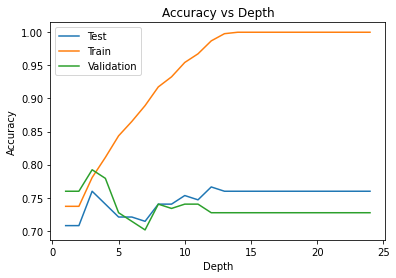

Optimal depth: 3
Number of nodes: 9

--------------------------------------------------PRUNING OPERATIONS--------------------------------------------------
X_train: (460, 8)
X_test: (154, 8)
X_val: (154, 8)
y_train: (460,)
y_test: (154,)
y_val: (154,)
Unpruned best tree accuracies:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       299
           1       0.96      0.91      0.93       161

    accuracy                           0.95       460
   macro avg       0.96      0.94      0.95       460
weighted avg       0.95      0.95      0.95       460

Training accuracy: 0.9543478260869566
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.64      0.67      0.65        54

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.76      0.75      0.75       154

Testing accuracy: 0.75324

In [ ]:
MAX_HEIGHT = 10
DATA_PATH = "/content/Dataset_E.csv"
MIN_LEAF_SIZE = 1 
MEASURE = "entropy"
RANDOM_SEED = 42

print(f"MAX DEPTH = {MAX_HEIGHT}")
print(f"DATA PATH = {DATA_PATH}")

if (MAX_HEIGHT < 0):
    MAX_HEIGHT = 10

print("-"*50 + "PREPROCESSING" + "-"*50)
feature_names = get_column_names(DATA_PATH)
X_full, y_full = get_X_y(DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, 0.8)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

run_entropy_exp(X_full=X_full, y_full=y_full,X_train_=X_train,y_train_=y_train,X_test_=X_test,y_test_=y_test)